In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import numpy.ma as ma
from skimage.filters import gaussian
import sys
sys.path.insert(1,"/Users/nityaravi/Documents/Github/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data


In [2]:
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
folder = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/'
fn = folder + 'H_alpha_HIvel_BB_extinction_H2_MxCG_R90_v3p5_Z_SFR_Portsmouthflux_Zglob.fits'
MANGA_FOLDER = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/'
NSA_FILENAME = '/Users/nityaravi/Documents/Research/RotationCurves/data/nsa_v1_0_1.fits'
VEL_MAP_FOLDER = MANGA_FOLDER + 'DR17/'

In [1]:
t = Table.read(fn, format='fits')
t_dict = {}
for i in range(0, len(t)):
    gal_ID = t['plateifu'][i]
    t_dict[gal_ID] = i

NameError: name 'Table' is not defined

In [20]:
def find_center(vel_map):
    '''
    Locate the center of the galaxy velocity map, defined as the position with
    the velocity value closest to 0.


    PARAMETERS
    ==========

    vel_map : numpy ndarray of shape (n,n)
        Masked H-alpha velocity map


    RETURNS
    =======

    center : numpy ndarray of shape (,2)
        Center coordinates of velocity map, [y,x] or [row, column]
    '''

    ############################################################################
    # Transform velocity map so that the 0th value is the maximum in the array
    # (including the masked points)
    #---------------------------------------------------------------------------
    neg_map = -np.abs(vel_map)
    shifted_neg_map = neg_map + np.abs(ma.min(vel_map))

    # Set all masked values to have a value of -1
    shifted_neg_map[vel_map.mask] = -1
    ############################################################################


    ############################################################################
    # Find the location of the maximum in the shifted negative map
    #---------------------------------------------------------------------------
    smoothed_map = gaussian(shifted_neg_map, sigma=2)

    center = np.unravel_index(np.argmax(smoothed_map), smoothed_map.shape)
    ############################################################################

    return center

def find_phi(center_coords, phi_angle, vel_map):
    '''
    Find a point along the semi-major axis that has data to determine if phi
    needs to be adjusted.  (This is necessary because the positive y-axis is
    defined as being along the semi-major axis of the positive velocity side of
    the velocity map.)


    PARAMETERS
    ==========

    center_coords : tuple
        Coordinates of the center of the galaxy

    phi_angle : float
        Initial rotation angle of the galaxy, E of N.  Units are degrees.

    vel_map : masked ndarray of shape (n,n)
        Masked H-alpha velocity map


    RETURNS
    =======

    phi_adjusted : float
        Rotation angle of the galaxy, E of N, that points along the positive
        velocity sector.  Units are radians.
    '''
    
    spax_jump = []
    spax = []
    
    # Convert phi_angle to radians
    phi = phi_angle*np.pi/180.
    
    print('phi: ', phi)

    # Extract "systemic" velocity (velocity at center spaxel)
    v_sys = vel_map[center_coords]

    f = 0.4

    checkpoint_masked = True

    while checkpoint_masked and not vel_map.mask.all():
        delta_x = center_coords[1]*f
        delta_y = delta_x/np.tan(phi)
        semi_major_axis_spaxel = np.array([int(center_coords[0] + delta_y), int(center_coords[1] - delta_x)])
        
        print('spax jump: ', semi_major_axis_spaxel)
        spax_jump.append([semi_major_axis_spaxel[0], semi_major_axis_spaxel[1]])
        
        in_map = True # check if pt along semi major axis is in the vel map
        
        for i in range(len(semi_major_axis_spaxel)):
            if semi_major_axis_spaxel[i] < 0:
                in_map = False
            elif semi_major_axis_spaxel[i] >= vel_map.shape[i]:
                in_map = False
        
        '''
        print('spax: ', semi_major_axis_spaxel)
        spax.append([semi_major_axis_spaxel[0], semi_major_axis_spaxel[1]])

        # Check value along semi-major axis
        if vel_map.mask[tuple(semi_major_axis_spaxel)] == 0:
            checkpoint_masked = False
        else:
            f *= 0.9'''
        
        if in_map == False:
            f *= 0.9
        elif vel_map.mask[tuple(semi_major_axis_spaxel)] == 0:
            checkpoint_masked=False
        else:
            f *= 0.9
            

    if vel_map.mask.all() or vel_map[tuple(semi_major_axis_spaxel)] - v_sys >= 0:
        phi_adjusted = phi
        print('no flip')
    else:
        phi_adjusted = phi + np.pi
        print('flip')

    print('new phi: ', phi_adjusted)

    return phi_adjusted, spax_jump, spax

In [25]:
gal_ID = '10507-3702'

i_t = t_dict[gal_ID]
phi_angle = t['nsa_elpetro_phi'][i_t]


maps = extract_data(VEL_MAP_FOLDER,
                    gal_ID,
                    ['Ha_vel', 'Ha_flux', 'Ha_sigma', 'r_band'])

vel = maps['Ha_vel']
vel_mask = maps['Ha_vel_mask']
vel_ivar = maps['Ha_vel_ivar']

Ha_flux = maps['Ha_flux']
Ha_flux_mask = maps['Ha_flux_mask']
Ha_flux_ivar = maps['Ha_flux_ivar']

Ha_sigma_ivar = maps['Ha_sigma_ivar']


vel_mask = np.logical_or(vel_mask > 0, np.abs(Ha_flux*np.sqrt(Ha_flux_ivar)) < 5)

mvel = ma.array( vel, mask=vel_mask)
    

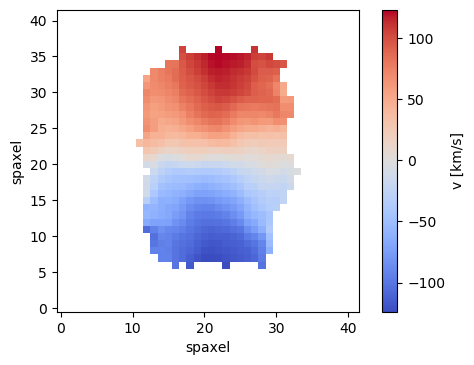

In [26]:
plt.imshow(mvel, cmap='coolwarm')
plt.colorbar(label='v [km/s]')
plt.xlabel('spaxel')
plt.ylabel('spaxel')
plt.gca().invert_yaxis()

In [27]:
center = find_center(mvel)
center

(20, 28)

In [29]:
newphi,_,_ = find_phi(center, phi_angle, mvel)
np.degrees(newphi)

phi:  3.0972787438816574
spax jump:  [-232   16]
spax jump:  [-207   17]
spax jump:  [-184   18]
spax jump:  [-164   19]
spax jump:  [-145   20]
spax jump:  [-129   21]
spax jump:  [-114   22]
spax jump:  [-100   22]
spax jump:  [-88  23]
spax jump:  [-77  23]
spax jump:  [-68  24]
spax jump:  [-59  24]
spax jump:  [-51  24]
spax jump:  [-44  25]
spax jump:  [-37  25]
spax jump:  [-32  25]
spax jump:  [-26  25]
spax jump:  [-22  26]
spax jump:  [-17  26]
spax jump:  [-14  26]
spax jump:  [-10  26]
spax jump:  [-7 26]
spax jump:  [-4 26]
spax jump:  [-2 27]
spax jump:  [ 0 27]
spax jump:  [ 1 27]
spax jump:  [ 3 27]
spax jump:  [ 5 27]
spax jump:  [ 6 27]
spax jump:  [ 8 27]
flip
new phi:  6.238871397471451


357.461

In [10]:
spax_jump

[[-232, 16],
 [-207, 17],
 [-184, 18],
 [-164, 19],
 [-145, 20],
 [-129, 21],
 [-114, 22],
 [-100, 22],
 [-88, 23],
 [-77, 23],
 [-68, 24],
 [-59, 24],
 [-51, 24],
 [-44, 25],
 [-37, 25],
 [-32, 25],
 [-26, 25],
 [-22, 26],
 [-17, 26],
 [-14, 26],
 [-10, 26],
 [-7, 26],
 [-4, 26],
 [-2, 27],
 [0, 27],
 [1, 27],
 [3, 27],
 [5, 27],
 [6, 27],
 [8, 27]]

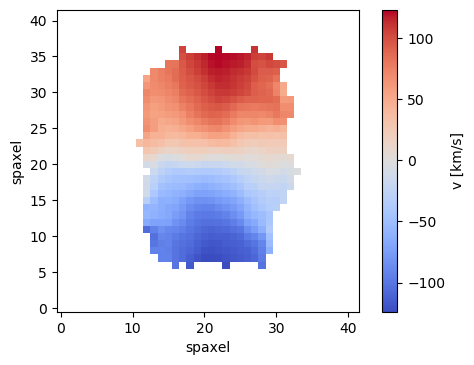

In [13]:
plt.imshow(mvel, cmap='coolwarm')
plt.colorbar(label='v [km/s]')
plt.xlabel('spaxel')
plt.ylabel('spaxel')
#for i in range(0,len(spax_jump)):
#    plt.scatter(spax_jump[i][1], spax_jump[i][0], marker='x', color='cyan')
    #plt.scatter(spax_jump[i][1], spax_jump[i][0], marker='x', color='k')
plt.gca().invert_yaxis()

plt.show()

In [210]:
mvel[(37,20)] - mvel[center]

-95.420074